## Simulation of in single intercalating quartet

This notebook implements the simulation of a symmetric lattice of identical cells to study individual T1 events in a simplified setting, for figure 4 of the paper "The geometric basis of epithelial convergent extension" by F. Brauns, N.H. Claussen, E.F. Wieschaus, and B.I. Shraiman.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from tqdm.notebook import tqdm

from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy import ndimage, linalg

import h5py

In [5]:
import jax.numpy as jnp
from jax import jit, grad
from jax import jacfwd, jacrev
from jax.config import config
config.update("jax_enable_x64", True) # 32 bit leads the optimizer to complain about precision loss

In [6]:
def eqspace(x0, x1, dx):
    return np.linspace(x0, x1, np.round(abs(x1-x0)/dx).astype(int))

In [7]:
# experimental tension data for reference

new_T_active = np.array([
[-24.77189690558106, 1.0438780872306885],
[-23.889848699669837, 1.0482951447069673],
[-22.81724982401174, 1.0580748867230492],
[-21.93501571500808, 1.065180102915952],
[-20.931572789736165, 1.0749648023478322],
[-19.9111507153551, 1.0802679978980558],
[-19.13234069344332, 1.0918609147423632],
[-18.371067529918008, 1.0998708593184547],
[-17.662095103064672, 1.101612151617605],
[-16.796592272380252, 1.11678308331433],
[-16.052236290266606, 1.1301705846776193],
[-15.290715255951376, 1.1417647408758764],
[-14.650712876391793, 1.1461991493074493],
[-14.079494641033522, 1.1560148325880686],
[-13.52587523175919, 1.1613514906949307],
[-12.816035257141156, 1.1756375236716607],
[-12.071617307330037, 1.1899210779404914],
[-11.448470141484645, 1.2006290960648034],
[-10.73894000535401, 1.2104348645138263],
[-10.063739973626546, 1.223827323292914],
[-9.318888249933075, 1.2443832479005348],
[-8.591883223113456, 1.256875935712232],
[-7.8300523503108295, 1.272950356438196],
[-7.137191524801949, 1.2917178932965825],
[-6.547816754082433, 1.3140770779008322],
[-5.907070762153104, 1.3292641211989016],
[-5.231436956543291, 1.348928950316779],
[-4.763704775974379, 1.3623362813432616],
[-4.192114734431236, 1.3775282820571295],
[-3.7588365936604546, 1.3927301976025939],
[-3.3084553683855695, 1.4052427150774847],
[-2.7539684113465306, 1.4231241138619262],
[-2.181758692828602, 1.4472766436312081],
[-1.557805946915991, 1.4696333495275584],
[-1.0893301539773326, 1.4937933154205378],
[-0.7079189759961899, 1.508998949027851],
[-0.17047313576378897, 1.5304657987884078],
[np.nan, np.nan],
[0.20969868826777827, 1.277750374284893],
[0.48464936198058695, 1.253537116172082],
[0.707423234416364, 1.2248473115934129],
[1.207440585371657, 1.2050982064069644],
[1.6553431027473984, 1.181768607660199],
[2.3104656004917743, 1.1548399250438734],
[2.6033249387759128, 1.1395859566325268],
[2.982567247345308, 1.123429738545891],
[3.431337312485752, 1.1126448804767053],
[4.035398427507715, 1.0973686036942665],
[4.656934433218652, 1.0847792462745023],
[5.31292447872773, 1.0703953043357561],
[5.743599976204408, 1.0479629978484817],
[6.313454922218149, 1.0380655172071904],
[6.762101051963633, 1.025488553326922],
[7.417905194380275, 1.0084164526715516],
[8.00473928950317, 0.9940374681486037],
[8.694749600928027, 0.9715865713520857],
[9.627177544889399, 0.9544946410335223],
[10.387149386767668, 0.9436874745932443],
[11.06042841987329, 0.9293022933005485],
[11.871957386053793, 0.9140111442707148],
[12.68367225532674, 0.9014081539575053],
[13.547563925876716, 0.893281710110154],
[14.39453841501502, 0.8905328230500009],
[15.103139035683483, 0.8868977979159027],
[15.846069760755114, 0.8796760824517398],
[16.676560842364097, 0.888577122517574],
[17.454379381116212, 0.8858331928732193],
[18.301477805649476, 0.884876411624149],
[18.99247960023399, 0.8767623613162931],
[19.718679046986388, 0.8776063613559526],
[20.21956394570639, 0.870401996847084],
[20.859442389871013, 0.8730442994675738],
[21.308646228893807, 0.8685318117371779],
[21.965627757562537, 0.8684847162870941],
[22.605939975609516, 0.8773993892463741],
[23.108188163674036, 0.889908188659416],
[23.57554853805808, 0.89793920225265],
[24.16269247166837, 0.8880404822574091],
[24.872594413983876, 0.9032225681396804]])


## Voronoi simulation

Let's only simulate the tensions for now. Convention: collapsing edge / collapsing angle is always _last_. Order: clockwise

In [8]:
rot90 = np.array([[0,1],[-1,0]])

In [9]:
def vectors_angle(a, b):
    """Angle between two vectors"""
    inner = (a@b)/np.sqrt((a@a)*(b@b))
    return np.arccos(np.clip(inner, -1, 1))

def sides_area(Ts):
    """Triangle area from side lengths."""
    Ts = np.sort(Ts, axis=0)[::-1]
    A = (Ts[0]+(Ts[1]+Ts[2]))*(Ts[2]-(Ts[0]-Ts[1]))*(Ts[2]+(Ts[0]-Ts[1]))*(Ts[0]+(Ts[1]-Ts[2]))/16
    return np.sqrt(np.clip(A, 0, np.inf))

def sides_circum(Ts):
    """Triangle circumcircle from side lengths"""
    R = np.prod(Ts, axis=0)/(4*sides_area(Ts))
    return R

def sides_angles(Ts):
    """Triangle angles from side lengths. Sorted so that angle [i] is opposite to Ts[i]"""
    R = sides_circum(Ts)
    inds = np.argmax(Ts, axis=0)
    # need to take the smaller two angles so as to avoid error in arcsin for angles >90
    phis = np.arcsin(Ts/(2*R))
    if isinstance(inds, np.ndarray):
        phis[inds, np.arange(len(inds))] = np.pi-(phis.sum(axis=0)-phis[inds, np.arange(len(inds))])
    else:
        phis[inds] = np.pi-(phis.sum(axis=0)-phis[inds])
    return phis

def angles_shape(phis):
    """Shape order parameter from angles"""
    alpha, beta, gamma = phis
    x = np.sqrt(3)*np.sin(alpha)*np.sin(alpha+2*beta)
    y = (np.cos(alpha)*np.cos(alpha+2*beta) - np.cos(2*alpha))
    psi = np.arctan2(x, y) + np.pi

    Psi = 6+2*(np.cos(4*phis)-np.cos(2*phis)
               -np.cos(2*(phis-np.roll(phis, 1, axis=0)))).sum(axis=0)
    Psi /= (3-np.cos(2*phis).sum(axis=0))**2
    Psi = np.sqrt(Psi)
    
    psi_tilde = np.pi - np.abs((3*psi) % (2*np.pi) - np.pi)
    
    return np.array([psi_tilde, Psi])

In [10]:
def cot(phi):
    return 1/np.tan(phi)

def get_voronoi_length(Ts):
    phis = sides_angles(Ts)
    return Ts[2]*cot(phis[2])

In [11]:
# for the new tensions post T1 there are two options, correpsonding to the two ways to build a kite
# out of two triangles

def get_Ts_post_T1(Ts, option=1):
    T1, T2 = (Ts[0], Ts[1]) # there remain the same
    angles_old = sides_angles(Ts)
    if option == 1:
        T0_new = np.sqrt(T1**2+T2**2 -2*T1*T2*np.cos(angles_old[0]+angles_old[1]))
    elif option == 2:
        T0_new = T1*np.sqrt(2-2*np.cos(2*angles_old[1]))
    return np.array([T1, T2, T0_new])

# get the passive tension post t1
def get_T_passive(Ts_old, Ts_new):
    T_active = (Ts_old[0]+Ts_old[1])-Ts_old[2]
    T_passive = Ts_new[2] - T_active
    return T_passive

In [12]:
# define feedback

def rhs(t, y, m=4, k=1, subtract_passive=False):
    Ts, Tps = (y[:3], y[3:])
    if subtract_passive:
        dT_dt = (Ts-Tps)**m - k*Tps
    else:
        dT_dt = Ts**m - k*Tps - 0.3*Ts**(m+1)
    dT_dt -= dT_dt.mean()
    #dT_dt -= ((Ts-Tps)**m).mean()
    
    dTp_dt = - k*Tps
    return np.hstack([dT_dt, dTp_dt])

max_phi = 1 * np.pi/2
def collapse_phi(t, y, k=None, m=None, subtract_passive=None):
    return max_phi - sides_angles(y[:3]).max()
collapse_phi.terminal = True

max_T = 1.53
def collapse_T(t, y, k=None, m=None, subtract_passive=None):
    return max_T - 2*y[2]/(y[0]+y[1])
collapse_T.terminal = True

## Dynamics up to intercalation

In [13]:
Ts_initial = np.array([1.0, 1.0, 1.1, 0, 0, 0])

In [14]:
t_span = (0, 2)
t_eval = np.linspace(*t_span, 500)

In [15]:
sol = solve_ivp(rhs, t_span, Ts_initial, t_eval=t_eval, args=(4, 2), rtol=1e-4, method='RK45', events=collapse_phi) 

Ts, Tps = (sol["y"][:3].T, sol["y"][3:].T)
ls = np.stack([get_voronoi_length(x) for x in Ts])
T_rel = 2*Ts[:,2]/(Ts[:,0]+Ts[:,1])

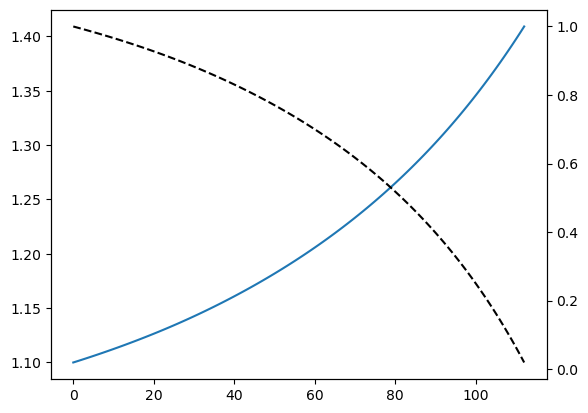

In [16]:
plt.plot(T_rel)

ax = plt.gca().twinx()
ax.plot(ls/ls[0], ls="dashed", color="k")

## dynamics with intercalation

In [17]:
t_span_post = (0, 1)
t_eval_post = np.linspace(*t_span_post, 250)

In [18]:
m = 4
k = 4
subtract_passive = False

Ts_initial = np.array([1.0, 1.01, 1.1, 0, 0, 0]) # bridge
#Ts_initial = np.array([1.0, 1.09, 1.1, 0, 0, 0]) # cable

In [19]:
sol_pre = solve_ivp(rhs, t_span, Ts_initial, t_eval=t_eval, events=collapse_phi, args=(m, k, subtract_passive),
                    rtol=1e-5, method='RK45') 
Ts_pre, Tps_pre = (sol_pre["y"][:3].T, sol_pre["y"][3:].T)

Ts_T1 = get_Ts_post_T1(Ts_pre[-1], option=2)
Tps = np.array([0, 0, get_T_passive(Ts_pre[-1], Ts_T1)])
Ts_initial_T1 = np.hstack([Ts_T1, Tps])

sol_post = solve_ivp(rhs, t_span_post, Ts_initial_T1, t_eval=t_eval_post, args=(m, k, subtract_passive),
                     rtol=1e-5, method='RK45') 
Ts_post, Tps_post = (sol_post["y"][:3].T, sol_post["y"][3:].T)

Ts_post[0,:] = np.nan # to create a break in the plots
Tps_post[0, :] = np.nan

Ts = np.vstack([Ts_pre, Ts_post])
Tps = np.vstack([Tps_pre, Tps_post])

phis = np.stack([sides_angles(x) for x in Ts])
ls = np.stack([get_voronoi_length(x) for x in Ts])
T_rel = 2*Ts[:,2]/(Ts[:,0]+Ts[:,1])

T_p = Tps[:,2]

/tmp/ipykernel_344934/2656728190.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  R = np.prod(Ts, axis=0)/(4*sides_area(Ts))
/tmp/ipykernel_344934/4270490111.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  return 1/np.tan(phi)


In [20]:
scale = 0.25
time = scale * (np.arange(T_rel.shape[0])-np.where(np.isnan(T_rel))[0][0])

(0.8, 1.5)

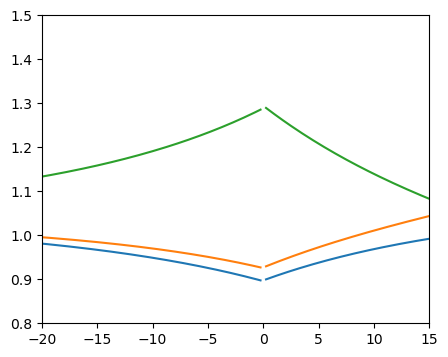

In [21]:
fig = plt.figure(figsize=(5,4))

plt.plot(time, Ts[:,0])
plt.plot(time, Ts[:,1])
plt.plot(time, Ts[:,2])

plt.xlim([-20, 15])
plt.ylim([.8, 1.5])

Text(0, 0.5, 'Length')

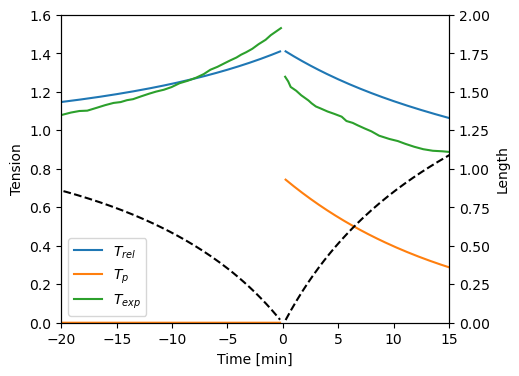

In [22]:
fig = plt.figure(figsize=(5,4))

plt.plot(time, T_rel, label=r"$T_{rel}$")
plt.plot(time, T_p, label=r"$T_{p}$")

plt.plot(new_T_active[:,0], new_T_active[:,1], label=r"$T_{exp}$")

plt.ylim([0, 1.6]) # 0.8, 1.6

plt.legend()
plt.ylabel("Tension")
plt.xlabel("Time [min]")

ax = plt.gca().twinx()
#ax.plot(time, ls/ls[0] + (1-2*(time > 0)) * 0.4, ls="dashed", color="k") # add isogonal correction
ax.plot(time, ls/ls[0], ls="dashed", color="k")


plt.xlim([-20, 15])
plt.ylim([-0, 2])
plt.ylabel("Length")

### Calculate lengths from tensions (=angles) using energy minimization

In [23]:
@jit
def get_edges(phis, ls):
    return jnp.array([[-ls[0]*jnp.sin(jnp.pi-phis[1]), -ls[0]*jnp.cos(jnp.pi-phis[1])],
                     [ls[1]*jnp.sin(jnp.pi-phis[0]), -ls[1]*jnp.cos(jnp.pi-phis[0])],
                     [0, -ls[2]]])

@jit
def get_metric_tensor(phis, ls):
    es = get_edges(phis, ls)
    units = (es.T / jnp.sqrt(jnp.sum(es**2, axis=1)+1e-5)).T
    g = (2/3)*jnp.einsum("ei,ej->ij", es, units)
    return g

@jit
def metric_energy(ls, phis=np.pi/3 * np.ones(3), g0=np.eye(2), mu=1, lam=1):
    g = get_metric_tensor(phis, ls)
    E = mu*jnp.trace(g-g0)**2 + lam*jnp.sum((g-g0)**2)
    return E

metric_energy_jac = jit(grad(metric_energy))

def get_lengths(phis, g0=np.eye(2), mu=1, lam=1):
    sol = minimize(metric_energy, np.ones(3), jac=metric_energy_jac, args=(phis, g0, mu, lam),
                   method='TNC', bounds=3*((0, None),),tol=1e-5, options={'mesg_num': None})
    if not sol["success"]:
        print(sol["message"])
    return sol["x"]

In [24]:
# define time over which to integrate

t_span_pre = (0, 2)
t_eval_pre = np.linspace(*t_span, 500)

t_span_post = (0, 1)
t_eval_post = np.linspace(*t_span_post, 250)

subtract_passive = False

In [25]:
def solve_single_quartet(Ts_initial, m=4, k=4, mu=1, lam=1, g0=np.eye(2)):
    g0_post = rot90 @ g0 @ rot90.T

    def collapse_pre(t, y, m=None, k=None, subtract_passive=None):
        phis = sides_angles(y[:3])
        ls = get_lengths(phis, g0=g0, mu=mu, lam=lam)
        return jnp.min(ls)-1e-3
    collapse_pre.terminal = True

    def collapse_post(t, y, m=None, k=None, subtract_passive=None):
        phis = sides_angles(y[:3])
        ls = get_lengths(phis, g0=g0_post, mu=mu, lam=lam)
        return jnp.min(ls[:2])-0.5*1e-3
    collapse_post.terminal = True

    
    # compute tension trajectories
    y0 = np.hstack([Ts_initial, np.zeros(3)])
    sol_pre = solve_ivp(rhs, t_span_pre, y0, t_eval=t_eval_pre, events=collapse_pre,
                        args=(m, k, subtract_passive), rtol=1e-5, method='RK45') 
    Ts_pre, Tps_pre = (sol_pre["y"][:3].T, sol_pre["y"][3:].T)
    
    Ts_T1 = get_Ts_post_T1(Ts_pre[-1], option=1)
    Tps = np.array([0, 0, get_T_passive(Ts_pre[-1], Ts_T1)])
    Ts_initial_T1 = np.hstack([Ts_T1, Tps])

    sol_post = solve_ivp(rhs, t_span_post, Ts_initial_T1, t_eval=t_eval_post, events=collapse_post,
                         args=(m, k, subtract_passive), rtol=1e-5, method='RK45') 
    Ts_post, Tps_post = (sol_post["y"][:3].T, sol_post["y"][3:].T)

    Ts_post[0,:] = np.nan
    Tps_post[0, :] = np.nan
    Ts = np.vstack([Ts_pre, Ts_post])
    T_rel = 2*Ts[:,2]/(Ts[:,0]+Ts[:,1])
    T_p = np.vstack([Tps_pre, Tps_post])[:,2]
    phis = np.stack([sides_angles(x) for x in Ts])
    time = (np.arange(T_rel.shape[0])-np.where(np.isnan(T_rel))[0][0])
    
    # calculate the lengths
    lengths = []
    for x, t in zip(phis, time):
        if t < 0:
            l = get_lengths(x, g0=g0, mu=1, lam=1)
        elif t == 0:
            l = np.nan * np.ones(3)
        elif t > 0:
            l = get_lengths(x, g0=g0_post, mu=1, lam=1)
        lengths.append(l)
    lengths = np.array(lengths)
    
    return time, lengths, phis, Ts, T_rel, T_p

In [26]:
Ts_initial = np.array([1, 1.04, 1.1]) 

iso = 0.33 
g0 = np.array([[1-iso, 0], [0, 1+iso]])

time, lengths, phis, Ts, T_rel, T_p = solve_single_quartet(Ts_initial, m=4, k=6, mu=1, lam=1, g0=g0)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [27]:
np.nanmax(T_rel)

1.626603295097528

Text(0, 0.5, 'Length')

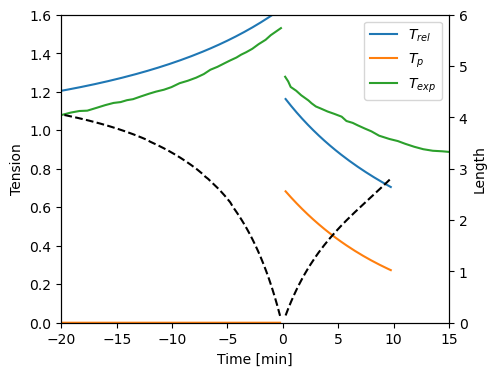

In [28]:
time_scale = 0.25 #0.25
length_scale = 4.5

fig = plt.figure(figsize=(5,4))

plt.plot(time_scale*time, T_rel, label=r"$T_{rel}$")
plt.plot(time_scale*time, T_p, label=r"$T_{p}$")

plt.plot(new_T_active[:,0], new_T_active[:,1], label=r"$T_{exp}$")

plt.ylim([0, 1.6]) # 0.8, 1.6

plt.legend()
plt.ylabel("Tension")
plt.xlabel("Time [min]")

ax = plt.gca().twinx()
ax.plot(time_scale*time, length_scale*lengths[:,2]/lengths[0,2], ls="dashed", color="k")

plt.xlim([-20, 15])
plt.ylim([-0, 6])
plt.ylabel("Length")


## Simulation with distribution of initial conditions

In [29]:
def align_collapse(to_align, t_eval_list, crop_quantile=0.2):
    shape_and_t0 = [(x.shape[0], np.where(x==0)[0][0]) for x in t_eval_list]
    pad_length = 5*max([max([y for x, y in shape_and_t0]), max([x-y for x, y in shape_and_t0])]) + 1
    all_array = np.nan * np.zeros((len(t_eval_list), pad_length)+to_align[0].T.shape[1:])
    for ix, ((shp, t0), traj) in enumerate(zip(shape_and_t0, to_align)):
        insert_ix = int(pad_length/2)-t0
        all_array[ix, insert_ix:insert_ix+shp] = traj.T
    # crop:
    i_crop = int(np.quantile(np.argmax(~np.isnan(all_array), axis=1), crop_quantile))
    all_array = all_array[:, i_crop:-i_crop]
    
    return all_array

In [30]:
exp_angle_series = []

with h5py.File('../data/body-vertex-angles_moving-avg-5.h5', 'r') as f:
    for t in range(1, 194):
        angles = f[f'TP{t}'][()]
        angles = np.pi - angles.astype(float) # convert real space to tension angles
        angles =  np.hstack([angles, np.pi-angles.sum(axis=-1)[:, np.newaxis]])
        exp_angle_series.append(angles)

angles_initial = np.sort(exp_angle_series[5], axis=1)

tensions_initial = 2*np.sin(angles_initial)
tensions_initial = (tensions_initial.T / tensions_initial.mean(axis=1)).T

In [31]:
# set parameters

iso = 0.16 #0.16 
g0 = np.array([[1-iso, 0], [0, 1+iso]])
m=4; k=5; mu=1; lam=1

In [32]:
times, lengths, T_rels = ([], [], [])

for Ts_initial in tqdm(tensions_initial[::50]):
    try:
        time, length, _, _, T_rel, _ = solve_single_quartet(Ts_initial, m=m, k=k, mu=mu, lam=lam, g0=g0)
    except:
        print("error")
        continue
    if (np.nanmax(T_rel) < 2.0) and (np.nanmin(T_rel) > 0.0):
        times.append(time)
        lengths.append(length[:,2])
        T_rels.append(T_rel)

  0%|          | 0/82 [00:00<?, ?it/s]

/tmp/ipykernel_344934/2656728190.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  R = np.prod(Ts, axis=0)/(4*sides_area(Ts))


In [33]:
# align

q = 0.2

tensions_array = align_collapse(T_rels, times, crop_quantile=q)
tensions_mean = np.nanmean(tensions_array, axis=0)
tensions_std = np.nanstd(tensions_array, axis=0)

lengths_array = align_collapse(lengths, times, crop_quantile=q)
lengths_mean = np.nanmean(lengths_array, axis=0)
lengths_std = np.nanstd(lengths_array, axis=0)

time_all = np.nanmean(align_collapse(times, times, crop_quantile=q), axis=0)

/tmp/ipykernel_344934/923535.py:6: RuntimeWarning: Mean of empty slice
  tensions_mean = np.nanmean(tensions_array, axis=0)
/home/nikolas/Programs/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_344934/923535.py:10: RuntimeWarning: Mean of empty slice
  lengths_mean = np.nanmean(lengths_array, axis=0)


In [34]:
np.nanmax(tensions_mean)

1.551408167087969

In [35]:
time_scale = 0.25 #0.25
length_scale = 4.25

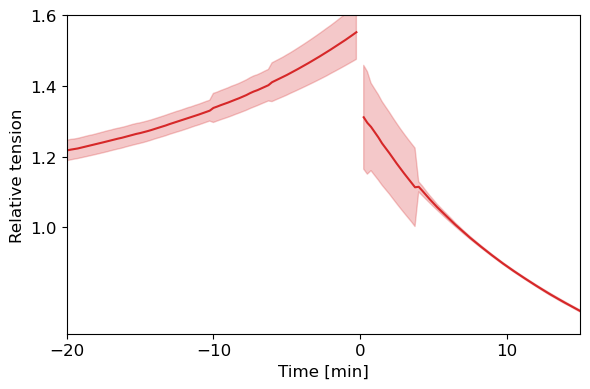

In [36]:
fig = plt.figure(figsize=(6,4))

plt.plot(time_scale*time_all, tensions_mean, color="tab:red",)
plt.fill_between(time_scale*time_all, tensions_mean-tensions_std, tensions_mean+tensions_std,
                 color="tab:red", alpha=0.25)

#plt.plot(new_T_active[:,0], new_T_active[:,1], color="tab:red", ls="dashed")

plt.ylim([0.7, 1.6]) # 0.8, 1.6
plt.xlim([-20, 15])

plt.ylabel("Relative tension", fontsize=12)
plt.xlabel("Time [min]", fontsize=12)

plt.xticks([-20, -10, 0, 10,], fontsize=12)
plt.yticks([1, 1.2, 1.4, 1.6], fontsize=12);

plt.tight_layout()
#plt.savefig("active_T1_relative_tension.pdf")

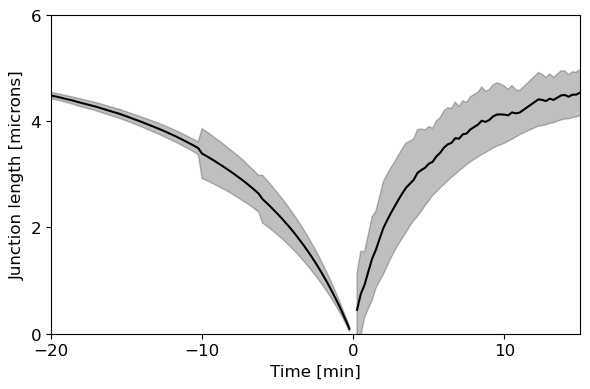

In [37]:
fig = plt.figure(figsize=(6,4))

plt.plot(time_scale*time_all, length_scale*lengths_mean, color="black")
plt.fill_between(time_scale*time_all, length_scale*(lengths_mean-lengths_std),
                 length_scale*(lengths_mean+lengths_std), color="black", alpha=0.25)


plt.ylim([0., 6]) # 0.8, 1.6
plt.xlim([-20, 15])

plt.ylabel("Junction length [microns]", fontsize=12)
plt.xlabel("Time [min]", fontsize=12)

plt.xticks([-20, -10, 0, 10,], fontsize=12)
plt.yticks([0, 2, 4, 6], fontsize=12);

plt.tight_layout()
#plt.savefig("active_T1_length.pdf")

## Making the movie

In [38]:
import ipywidgets as widgets
import functools
from matplotlib import animation, rc

In [39]:
@jit
def get_vertices(phis, ls):
    """Hexagons labeled 1-4 clockwise, with 1 at the "top". Origin (0,0) in the middle of collapsing edge"""
    edges = get_edges(phis, ls)
    segments = jnp.stack([jnp.array([0,0]), edges[0], -edges[2], edges[1], -edges[0], edges[2]])
    poly = jnp.cumsum(segments, axis=0)
    poly1 = poly - edges[2]/2
    poly3 = -poly + edges[2]/2
    
    poly2 = poly + edges[2]/2 - edges[1]
    poly4 = poly + edges[2]/2 - edges[0]

    return jnp.stack([poly1, poly2, poly3, poly4])

@jit
def get_centroids(phis, ls):
    vertices = get_vertices(phis, ls)
    return jnp.mean(vertices, axis=1)

In [40]:
# run the simulation

Ts_initial = np.array([1, 1, 1.095]) 

iso = 0.17 
g0 = np.array([[1-iso, 0], [0, 1+iso]])

time, lengths, phis, Ts, T_rel, T_p = solve_single_quartet(Ts_initial, m=4, k=6, mu=1, lam=1, g0=g0)

time = 0.25*time

In [41]:
time[0], time[140]

(-33.75, 1.25)

In [42]:
# compute the vertex positions

vertices = np.stack([get_vertices(a, b) for a, b in  zip(phis, lengths)])
flip = np.where(np.isnan(lengths))[0][0]
vertices = np.stack([x if ix < flip else np.einsum("ij, abj->abi", rot90, x) for ix, x in enumerate(vertices)])

# compute the tension triangulation 

tris = []
for phi, T in zip(phis, Ts):
    R = sides_circum(T)
    tri = np.array([[0,0],
                    [T[2], 0],
                    [T[1]*np.cos(phi[0]), T[1]*np.sin(phi[0])]])
    tri = tri - np.array([T[2]/2, 0])
    tris.append(tri)
tris = np.stack([x if ix < flip else np.einsum("ij, aj->ai", rot90, x) for ix, x in enumerate(tris)])

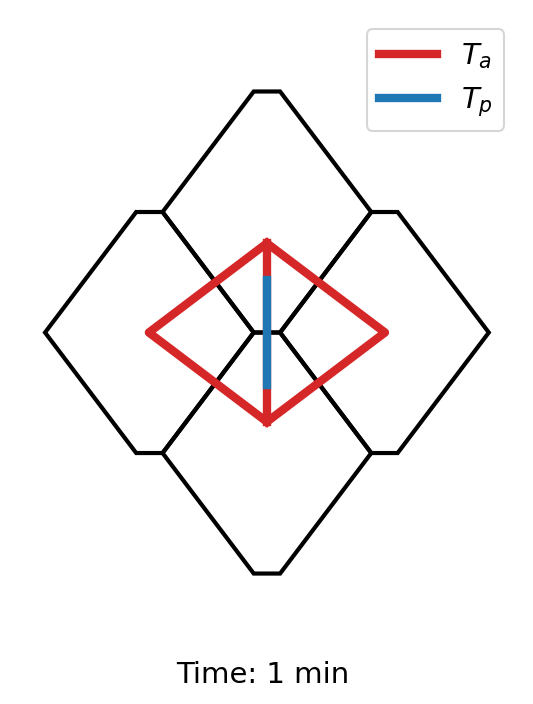

In [43]:
fig, ax = plt.subplots(figsize=(5.5,5.5), facecolor="white", dpi=150,)

R_tri = 1.5  # scale


def plot_frame(i):
    ax.cla()
    if i == flip:
        i = i-1
    for poly in vertices[i]:
        patch = mpl.patches.Polygon(poly, fill=False, lw=2)
        ax.add_patch(patch)
     
    ax.plot(R_tri*tris[i,0:2,0], R_tri*tris[i,0:2,1], lw=4, color="tab:red")
    ax.plot(R_tri*np.roll(tris[i,:,0], 2), R_tri*np.roll(tris[i,:,1], 2), lw=4, color="tab:red")

    if i < flip:
        ax.plot(R_tri*np.roll(tris[i,:,0], 2), -R_tri*np.roll(tris[i,:,1], 2), lw=4, color="tab:red")
    else:
        ax.plot(-R_tri*np.roll(tris[i,:,0], 2), R_tri*np.roll(tris[i,:,1], 2), lw=4, color="tab:red")

    if (T_p[i]) > 0.05:
        plt.plot([0,0], [-R_tri*T_p[i]/2, R_tri*T_p[i]/2], color="tab:blue", lw=4)    

    ax.plot([], [], color="tab:red", lw=4, label=r"$T_a$")    
    ax.plot([], [], color="tab:blue", lw=4, label=r"$T_p$")    

    ax.text(-.83, -3.2, f"Time: {round(time[i])} min", fontsize=14, horizontalalignment="left")

    ax.legend(fontsize=14, loc="upper right")
    ax.set_xlim([-2.3, 2.3])
    ax.set_ylim([-2.9, 2.9])
    ax.set_aspect("equal")
    ax.axis("off")
    
plot_frame(140)


#nframes, frame_dt = 140, 10  

# run the animation
#anim = animation.FuncAnimation(fig, plot_frame, frames=nframes, interval=frame_dt, repeat=False)
#anim.save('single_quartet_v4.mp4', fps=30, extra_args=['-vcodec','libx264'])

## Computing the tension isogonal decomposition

For this, an additional complication is that we might need to rotate the quartet so that it's intertia tensor remains aligned with the vertical axis

In [44]:
@jit
def corrot_frame(centroids):
    """Returns rotation matrix"""
    l1 = centroids[0]-centroids[2]
    l1 = np.array([[0, 1],[-1, 0]])@(l1/jnp.linalg.norm(l1))
    l2 = centroids[3]-centroids[1]
    l2 = l2/jnp.linalg.norm(l2)
    l = l1+l2
    l = l/jnp.linalg.norm(l)
    theta = jnp.arctan2(l[1], l[0])
    rot_mat = jnp.array([[jnp.cos(theta), jnp.sin(theta)],[-jnp.sin(theta), jnp.cos(theta)]])
    
    return rot_mat
    
# get shape tensor from centroids, and translate it to co-rotating frame
@jit
def get_shape_tensor(centroids):
    edges = centroids - jnp.roll(centroids, 1, axis=0)
    return jnp.einsum('ei,ej->ij', edges, edges)/2

In [45]:
@jit
def get_tri_pts_from_angles(phis):
    """convention: circumcircle 1/sqrt(3)"""
    R= 1/jnp.sqrt(3)
    segments = jnp.array([jnp.array([0,0]),
                          2*R*jnp.sin(phis[2]) * jnp.array([1, 0]), 
                          2*R*jnp.sin(phis[1])*jnp.array([-jnp.cos(phis[0]), jnp.sin(phis[0])])])
    return np.cumsum(segments, axis=0)

@jit
def get_voronoi_centroids(phis):
    """Scaled to make it match the centroids if the rest length is 1"""
    pts = get_tri_pts_from_angles(phis)
    pts = pts-(pts[0]+pts[1])/2
    return jnp.sqrt(3)* jnp.stack([pts[2], pts[1], -pts[2], pts[0]])

In [46]:
# master function which returns physical, voronoi, and isogonal metric tensors

def get_aspect(metric):
    return np.sqrt(metric[0,0]/metric[1,1])

def get_aspect_ratios(phis, ls):
    # get the centroids, transform to co-rotating frame
    centroids_phys = get_centroids(phis, ls)
    centroid_vor = get_voronoi_centroids(phis)
    frame = corrot_frame(centroids_phys)
    centroids_phys, centroid_vor = [(frame @ x.T).T for x in [centroids_phys, centroid_vor]]
    
    # get isogonal modes by least-squares fit
    e_phys = centroids_phys-np.roll(centroids_phys, 1, axis=0)
    e_vor = centroid_vor-np.roll(centroid_vor, 1, axis=0)
    lstsq_fit = np.linalg.lstsq(e_vor, e_phys, rcond=None)[0]
    I = (lstsq_fit+lstsq_fit.T)/2

    # compute the shape tensors. square isogonal so that it matches.
    physical, voronoi, isogonal = (get_shape_tensor(centroids_phys), get_shape_tensor(centroid_vor), I@I)
    
    return [get_aspect(x) for x in [physical, voronoi, isogonal]]

In [47]:
times, lengths, aspects = ([], [], [])

for Ts_initial in tqdm(tensions_initial[::10]):
    try:
        time, ls, phis, _, T_rel, _ = solve_single_quartet(Ts_initial, m=m, k=k, mu=mu, lam=lam, g0=g0)
    except:
        print("error")
        continue
    if (np.nanmax(T_rel) < 2.0) and (np.nanmin(T_rel) > 0.0):
        times.append(time)
        lengths.append(ls[:,2])
        aspect = np.array([get_aspect_ratios(phi, l) if not np.isnan(phi).any()
                     else [np.nan, np.nan, np.nan] for phi, l in zip(phis, ls)]).T
        aspects.append(aspect)

  0%|          | 0/408 [00:00<?, ?it/s]

/tmp/ipykernel_344934/2656728190.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  R = np.prod(Ts, axis=0)/(4*sides_area(Ts))


In [48]:
# align

q = 0.2

aspect_array = np.log(align_collapse(aspects, times))
aspects_mean = np.nanmean(aspect_array, axis=0)
aspects_std = np.nanstd(aspect_array, axis=0)

lengths_array = align_collapse(lengths, times, crop_quantile=q)
lengths_mean = np.nanmean(lengths_array, axis=0)
lengths_std = np.nanstd(lengths_array, axis=0)

time_all = np.nanmean(align_collapse(times, times, crop_quantile=q), axis=0)

sign = np.sign(time_all)
lengths_mean *= sign
lengths_mean *= length_scale

aspects_mean = -aspects_mean.T *sign
aspects_std = aspects_std.T *sign

/tmp/ipykernel_344934/3849029665.py:6: RuntimeWarning: Mean of empty slice
  aspects_mean = np.nanmean(aspect_array, axis=0)
/tmp/ipykernel_344934/3849029665.py:10: RuntimeWarning: Mean of empty slice
  lengths_mean = np.nanmean(lengths_array, axis=0)


Text(0, 0.5, 'Aspect ratio')

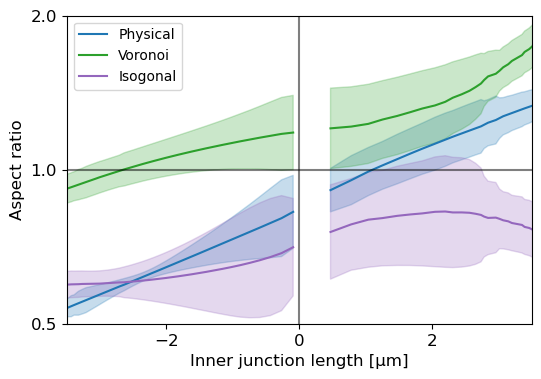

In [49]:
fig = plt.figure(figsize=(6,4))

plt.plot(lengths_mean, aspects_mean[0], color='tab:blue', label="Physical")
plt.fill_between(lengths_mean, aspects_mean[0]-aspects_std[0],
                 aspects_mean[0]+aspects_std[0], color='tab:blue', alpha=.25)

plt.plot(lengths_mean, aspects_mean[1], color='tab:green', label="Voronoi")
plt.fill_between(lengths_mean, aspects_mean[1]-aspects_std[1],
                 aspects_mean[1]+aspects_std[1], color='tab:green', alpha=.25)

plt.plot(lengths_mean, aspects_mean[2], color='tab:purple', label="Isogonal")
plt.fill_between(lengths_mean, aspects_mean[2]-aspects_std[2],
                 aspects_mean[2]+aspects_std[2], color='tab:purple', alpha=.25)

plt.hlines(0, -5, 5, color="k", alpha=.5)
plt.vlines(0, np.log(1/2)-.1, np.log(2)+.1, color="k", alpha=.5)

plt.legend()

plt.xticks([-2, 0, 2], fontsize=12)
plt.yticks(np.log(np.array([.5, 1, 2])), np.array([.5, 1, 2]), fontsize=12)
plt.ylim([np.log(1/2), np.log(2)])
plt.xlim([-3.5, 3.5])

plt.xlabel("Inner junction length [μm]", fontsize=12)
plt.ylabel("Aspect ratio", fontsize=12)

#plt.savefig('active_T1_aspect.pdf', bbox_inches="tight")

## Passive intercalations

Now determine cell shape (angle and length) by balance of elasticity and externally imposed shear

In [50]:
@jit
def get_passive_energy_pre(x, shear_mat=np.eye(2), g0=np.eye(2), lam=1, mu=1, penalty=10, reg=.01,):
    """Arguments: two angles (third is infered) for constrained minimization"""    
    phis, ls = (x[:2], x[2:])
    phis = jnp.hstack([phis, [jnp.pi-jnp.sum(phis)]])
    
    delta = get_metric_tensor(phis, ls) - g0
    E_shape = mu*jnp.trace(delta)**2 + lam*jnp.sum((delta)**2)
    
    centroid_ref = get_centroids(np.pi/3*np.ones(3), np.ones(3)).T
    centroid_sheared = shear_mat @ centroid_ref
    centroid = get_centroids(phis, ls).T
    E_penalty = penalty*jnp.sum((centroid_sheared-centroid)**2)
    
    E_angle = reg*jnp.sum((phis - jnp.array([jnp.pi/3, jnp.pi/3, jnp.pi/3]))**2)
    
    return E_penalty + E_shape + E_angle

@jit
def get_passive_energy_post(x, shear_mat=np.eye(2), g0=np.eye(2), lam=1, mu=1, penalty=10, reg=.01):
    """Arguments: two angles (third is infered) for constrained minimization"""    
    phis, ls = (x[:2], x[2:])
    phis = jnp.hstack([phis, [jnp.pi-jnp.sum(phis)]])
    
    delta = get_metric_tensor(phis, ls) - g0
    E_shape = mu*jnp.trace(delta)**2 + lam*jnp.sum((delta)**2)
    
    centroid_ref = get_centroids(np.pi/3*np.ones(3), np.ones(3)).T
    centroid_sheared = shear_mat @ centroid_ref
    centroid = jnp.roll(jnp.array([[0,1],[-1,0]]) @ get_centroids(phis, ls).T, -1, axis=1)
    E_penalty = penalty*jnp.sum((centroid_sheared-centroid)**2)
    
    E_angle = reg*jnp.sum((phis - jnp.array([jnp.pi/6, jnp.pi/6, 2*jnp.pi/3]))**2)
    
    return E_penalty + E_shape + E_angle

passive_energy_pre_jac = jit(grad(get_passive_energy_pre), static_argnums=6)
passive_energy_post_jac = jit(grad(get_passive_energy_post), static_argnums=6)

@jit
def get_shear(s, theta):
    """Get pure shear matrix"""
    rot_mat = jnp.array([[jnp.cos(theta), jnp.sin(theta)],[-jnp.sin(theta), jnp.cos(theta)]])
    shear_mat = jnp.array([[s,0], [0, 1/s]])
    return rot_mat@shear_mat@rot_mat.T
    

def get_passive(shear_mat, g0=np.eye(2), lam=1,  mu=1, penalty=10, pre=True):
    if pre:
        initial = np.hstack([np.pi/3*np.ones(2), np.ones(3)])
        sol = minimize(get_passive_energy_pre, initial, args=(shear_mat, g0, lam, mu, penalty),
                       bounds=2*((0, jnp.pi),)+3*((0, None),), jac=passive_energy_pre_jac,
                       method='TNC', tol=1e-7, options={'maxfun': 10000})
    else:
        initial = np.hstack([np.pi/6*np.ones(2), np.array([1.5, 1.5, .1])])
        sol = minimize(get_passive_energy_post, initial, args=(shear_mat, g0, lam, mu, penalty),
               bounds=2*((0, jnp.pi),)+3*((0, None),), jac=passive_energy_post_jac,
                       method='TNC', tol=1e-7, options={'maxfun': 10000})

    if not sol["success"]:
        print(sol["message"])
    phis, ls = (sol["x"][:2], sol["x"][2:])
    phis = np.hstack([phis, [jnp.pi-jnp.sum(phis)]])
    return phis, ls, sol["fun"]

In [51]:
## get full trajectory of a passive intercalation event

def get_trajectory(theta, mu=1, lam=.1, penalty=25, dt=.01, t_range=(0,1)):
    t_all = eqspace(*t_range, dt)

    phis_traj, ls_traj, E_traj, t_eval = ([], [], [], [])
    g0 = np.eye(2)
    pre = True
    
    for t in t_all:
        shear_mat = get_shear(jnp.exp(t), theta)
        phis, ls, E = get_passive(shear_mat, g0=g0, lam=lam,  mu=mu, penalty=penalty, pre=pre)
        phis_traj.append(phis); ls_traj.append(ls), E_traj.append(E), t_eval.append(t)
        if jnp.min(ls) < .01:
            g0 = rot90 @ get_metric_tensor(phis, ls) @ rot90.T
            t_eval[-1] = np.nan
            phis_traj[-1] = np.nan * np.ones(3)
            ls_traj[-1] = np.nan * np.ones(3)      
            E_traj[-1] = np.nan
            pre = False
    phis_traj = np.array(phis_traj); ls_traj = np.array(ls_traj); E_traj = np.array(E_traj)
    t_eval = np.array(t_eval)
    t_eval -= t_eval[np.argmax(np.isnan(t_eval))-1]+dt
    
    return phis_traj, ls_traj, E_traj, t_eval

In [52]:
## simulate a single passive T1 event

phis_traj, ls_traj, E_traj, t_eval = get_trajectory(10*np.pi/180, mu=1, lam=.05, penalty=25)

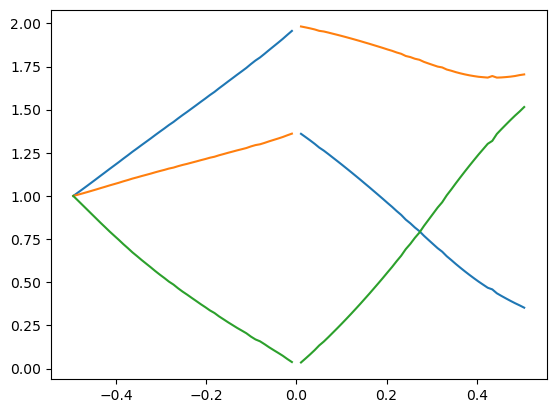

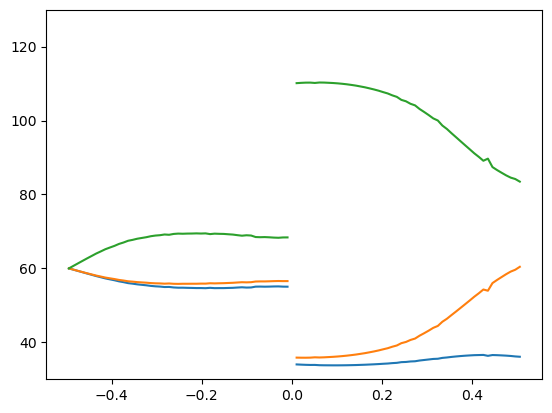

In [53]:
plt.plot(t_eval, ls_traj)  # lengths
plt.show()

plt.plot(t_eval, phis_traj*180/np.pi) # angles
plt.ylim([30, 130])
plt.show()

### run full simulation for plots

In [71]:
def align_collapse(to_align, t_eval_list, crop_quantile=0.2):
    shape_and_t0 = [(x.shape[0], np.where(np.isnan(x))[0][0]) for x in t_eval_list]
    pad_length = 5*max([max([y for x, y in shape_and_t0]), max([x-y for x, y in shape_and_t0])]) + 1
    all_array = np.nan * np.zeros((len(t_eval_list), pad_length)+to_align[0].T.shape[1:])
    for ix, ((shp, t0), traj) in enumerate(zip(shape_and_t0, to_align)):
        insert_ix = int(pad_length/2)-t0
        all_array[ix, insert_ix:insert_ix+shp] = traj.T
    # crop:
    i_crop = int(np.quantile(np.argmax(~np.isnan(all_array), axis=1), crop_quantile))
    all_array = all_array[:, i_crop:-i_crop]
    
    return all_array

def mysign(x): return 1-2*(x<=0)

from scipy import interpolate

def fill_nan(A):
    '''
    interpolate to fill nan values
    '''
    inds = np.arange(A.shape[0])
    good = np.where(np.isfinite(A))
    f = interpolate.interp1d(inds[good], A[good], bounds_error=False)
    B = np.where(np.isfinite(A),A,f(inds))
    return B

In [68]:
mu = 1
lam = 0.01
penalty = 100
dt = .01

In [66]:
# loop over strain angles

lengths_list = []
phis_list = []
aspects_list = []
t_eval_list = []

thetas = np.arange(0, 20) * np.pi/180

for theta in tqdm(thetas):
    phis, lengths, _, t_eval = get_trajectory(theta, mu=mu, lam=lam, penalty=penalty, dt=dt, t_range=(0, 2))
    aspects = np.array([get_aspect_ratios(phi, l) if not np.isnan(phi).any()
                         else [np.nan, np.nan, np.nan] for phi, l in zip(phis, lengths)]).T
    #t_eval[np.isnan(t_eval)]
    # order: physical, voronoi, isogonal
    lengths_list.append(lengths)
    phis_list.append(phis)
    t_eval_list.append(t_eval)
    aspects_list.append(aspects)

  0%|          | 0/20 [00:00<?, ?it/s]

Max. number of function evaluations reached


In [69]:
## calculate relative tensions, and inner lengths

def get_rel_tension(phis):
    return 2*jnp.sin(phis)[:,2] / (jnp.sin(phis)[:,0]+jnp.sin(phis)[:,1])

inner_length_list = [x[:,-1] for x in lengths_list]
T_rel_list = [get_rel_tension(x) for x in phis_list]

times_all = np.nanmean(align_collapse(t_eval_list, t_eval_list), axis=0)

/tmp/ipykernel_344934/1868840096.py:9: RuntimeWarning: Mean of empty slice
  times_all = np.nanmean(align_collapse(t_eval_list, t_eval_list), axis=0)


/tmp/ipykernel_344934/663412513.py:9: RuntimeWarning: Mean of empty slice
  mean_length = l_scale*sign*np.nanmean(all_array_length, axis=0)
/tmp/ipykernel_344934/663412513.py:11: RuntimeWarning: Mean of empty slice
  mean = -np.nanmean(np.log(all_array), axis=0).T  * sign


Text(0, 0.5, 'Aspect ratio')

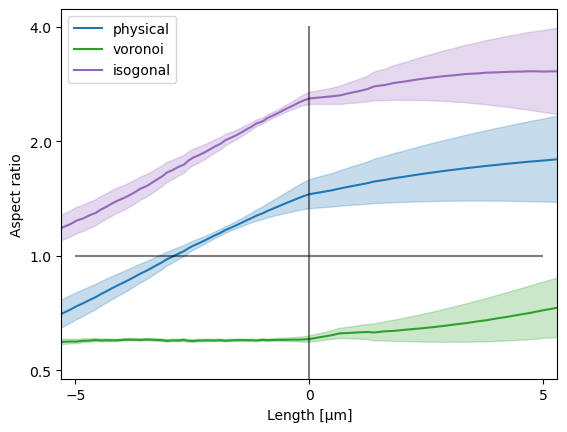

In [72]:
all_array = align_collapse(aspects_list, t_eval_list)

t_scale = 25/0.6
l_scale = 7

sign = mysign(times_all)

all_array_length = align_collapse(inner_length_list, t_eval_list)
mean_length = l_scale*sign*np.nanmean(all_array_length, axis=0)

mean = -np.nanmean(np.log(all_array), axis=0).T  * sign
std = np.nanstd((np.log(all_array).transpose((0,2,1))* sign).transpose((0,2,1)), axis=0).T

ifix = np.where(np.isnan(times_all))[0][0]+1
mean[:,ifix] = std[:,ifix] = np.nan

mean = np.stack([fill_nan(x) for x in mean])
std = np.stack([fill_nan(x) for x in std])
mean_length = fill_nan(mean_length)
mean_length -= mean_length[ifix-2]

std = ndimage.gaussian_filter1d(std, axis=1, sigma=5)



plt.plot(mean_length, mean[0], color='tab:blue', label="physical")
plt.fill_between(mean_length, mean[0]-std[0], mean[0]+std[0], color='tab:blue', alpha=.25)

plt.plot(mean_length, mean[1], color='tab:green', label="voronoi")
plt.fill_between(mean_length, mean[1]-std[1], mean[1]+std[1], color='tab:green', alpha=.25)

plt.plot(mean_length, fill_nan(mean[2]), color='tab:purple', label="isogonal")
plt.fill_between(mean_length, mean[2]-std[2], mean[2]+std[2], color='tab:purple', alpha=.25)

plt.hlines(0, -5, 5, color="k", alpha=.5)
plt.vlines(0, np.log(1/2)-.1, np.log(2)+.7, color="k", alpha=.5)

plt.legend()

plt.xticks([-5, 0, 5])
plt.yticks(np.log(np.array([.5, 1, 2, 4])), np.array([.5, 1, 2, 4]))
plt.ylim([np.log(1/2)-.05, np.log(2)+.8])

plt.xlim([-5.3, 5.3])

plt.xlabel("Length [μm]")
plt.ylabel("Aspect ratio")

#plt.savefig('panels_v2/passive_T1_aspect_pm20_deg.pdf', bbox_inches="tight")

/tmp/ipykernel_344934/1374278274.py:3: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(all_array, axis=0)


(0.5, 1.8)

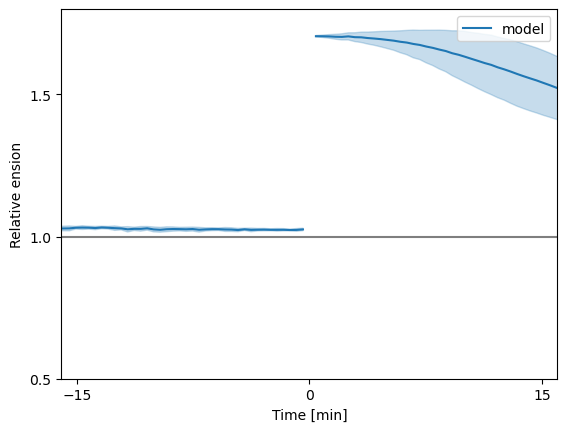

In [74]:
all_array = align_collapse(T_rel_list, t_eval_list)

mean = np.nanmean(all_array, axis=0)
std = np.nanstd(all_array, axis=0)

t_scale = 25/0.6

plt.plot(t_scale*times_all, mean, color='tab:blue', label="model")
plt.legend()

plt.fill_between(t_scale*times_all, mean-std, mean+std, color='tab:blue', alpha=.25)
plt.hlines(1, t_scale*times_all[0], t_scale*times_all[-1] , color="k", alpha=.5)

plt.yticks([.5, 1, 1.5])
plt.xticks([-25, -15, 0, 15, 20])

plt.ylabel("Relative ension")
plt.xlabel("Time [min]")

plt.xlim([-16, 16])
plt.ylim([.5, 1.8])


/tmp/ipykernel_344934/711595068.py:6: RuntimeWarning: Mean of empty slice
  mean = l_scale*np.nanmean(all_array, axis=0)


(0.0, 8.1)

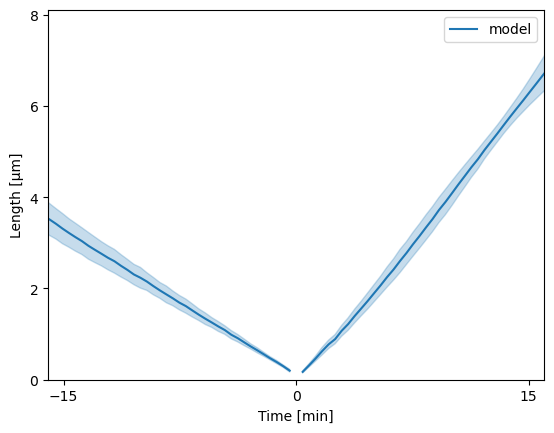

In [75]:
all_array = align_collapse(inner_length_list, t_eval_list)

t_scale = 25/0.6
l_scale = 5.5

mean = l_scale*np.nanmean(all_array, axis=0)
std = l_scale*np.nanstd(all_array, axis=0)

plt.plot(t_scale*times_all, mean, color='tab:blue', label="model")
plt.legend()

plt.fill_between(t_scale*times_all, mean-std, mean+std, color='tab:blue', alpha=.25)

plt.yticks([0, 2, 4, 6, 8,])
#plt.xticks([-15, 0, 15])
plt.xticks([-25, -15, 0, 15, 20])

plt.ylabel("Length [μm]")
plt.xlabel("Time [min]")

plt.xlim([-16, 16])
plt.ylim([0, 8.1])
